In [1]:
# utilities
import re
import pandas as pd
import joblib
import string
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
tweets = pd.read_csv(r'D:\Lets Go\Data Learning Fall 2021\Twitter API\politician tweets.csv')
tweets = tweets.drop('Unnamed: 0',axis=1)
tweets.head()

,User,Tweet
0,Alexandria Ocasio-Cortez,People think Fox News is just about indoctrina...
1,Alexandria Ocasio-Cortez,“Woke” is a term pundits are now using as a de...
2,Alexandria Ocasio-Cortez,One dangerous aspect of thinking there’s a “wo...
3,Alexandria Ocasio-Cortez,@saschasegan @ThesillyDane It was on the table...
4,Alexandria Ocasio-Cortez,"We can and should message BIF as a step, but m..."


In [3]:
# All processing methods copied from model building notebook
stops = stopwords.words('english')
def remove_stops(text):
    return " ".join([word for word in str(text).split() if word not in stops])
tweets['Tweet'] = tweets['Tweet'].apply(lambda x: remove_stops(x))

def convert_emotes(text):
    happy = [':)','(:',':D',';)','(;',';D',':‑)',':-]',':]',':-3',':3',':->',':>','8-)',':^)',':*)']
    sad = [':(','):','D:',';(',');','>:(',':-(',':,(',':[',':-[',':-<',':<','D;','8-(','8(',':*(']
    happy_matches = [x for x in happy if x in text.split(' ')]
    sad_matches = [y for y in sad if y in text.split(' ')]
    if len(happy_matches)>0:
        text = re.sub(re.escape(happy_matches[0]),'happy',text)
    if len(sad_matches)>0:
        text = re.sub(re.escape(sad_matches[0]),'sad',text)
    return text
tweets['Tweet'] = tweets['Tweet'].apply(lambda x: convert_emotes(x))

english_puncts = string.punctuation
punct_list = english_puncts
def clean_punct(text):
    trans = str.maketrans('','',punct_list)
    return text.translate(trans)
tweets['Tweet'] = tweets['Tweet'].apply(lambda x: clean_punct(x))

def clean_urls(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))','',data)
tweets['Tweet'] = tweets['Tweet'].apply(lambda x: clean_urls(x))

def clean_nums(data):
    return re.sub('[0-9]+','',data)
tweets['Tweet'] = tweets['Tweet'].apply(lambda x: clean_nums(x))

lm = WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
tweets['Tweet'] = tweets['Tweet'].apply(lambda x: lemmatizer_on_text(x))


tweets['Tweet'] = tweets['Tweet'].apply(lambda x: word_tokenize(x))

tweets['Tweet'] = tweets['Tweet'].astype(str)
X = tweets['Tweet'].values

tweets['Tweet'].head()

0    ['People', 'think', 'Fox', 'News', 'indoctrina...
1    ['“', 'Woke', '”', 'term', 'pundits', 'using',...
2    ['One', 'dangerous', 'aspect', 'thinking', 'th...
3    ['saschasegan', 'ThesillyDane', 'It', 'table',...
4    ['We', 'message', 'BIF', 'step', 'messaging', ...
Name: Tweet, dtype: object

In [4]:
# Load vectorizer and Logistic Regression Model
vect = joblib.load('vect.pkl')
lrmodel = joblib.load('lrmodel.pkl')

In [5]:
# Transform and predict on data
X = vect.transform(X)
preds = lrmodel.predict(X)

In [6]:
# Combine predictions with tweets
tweets_w_preds = pd.concat([tweets,pd.Series(data=preds,name='Predicted Sentiment')],axis=1)
tweets_w_preds['Predicted Sentiment'] = tweets_w_preds['Predicted Sentiment'].map({1:'Pos',0:'Neg'})

In [7]:
df_plot = tweets_w_preds.groupby(['User','Predicted Sentiment']).size().reset_index().pivot(columns='Predicted Sentiment', index='User', values=0)

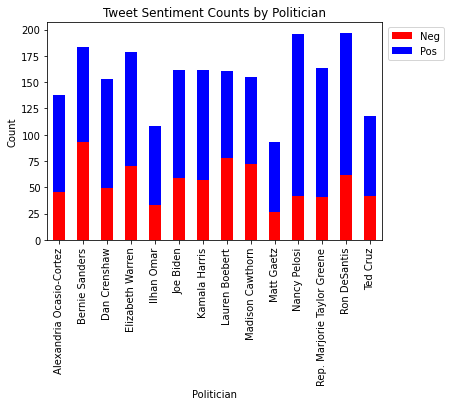

In [8]:
df_plot.plot(kind='bar',stacked=True,colormap='bwr_r')
plt.legend(loc='upper right',bbox_to_anchor=(1.2,1))
plt.title('Tweet Sentiment Counts by Politician')
plt.xlabel('Politician')
plt.ylabel('Count')
plt.show()

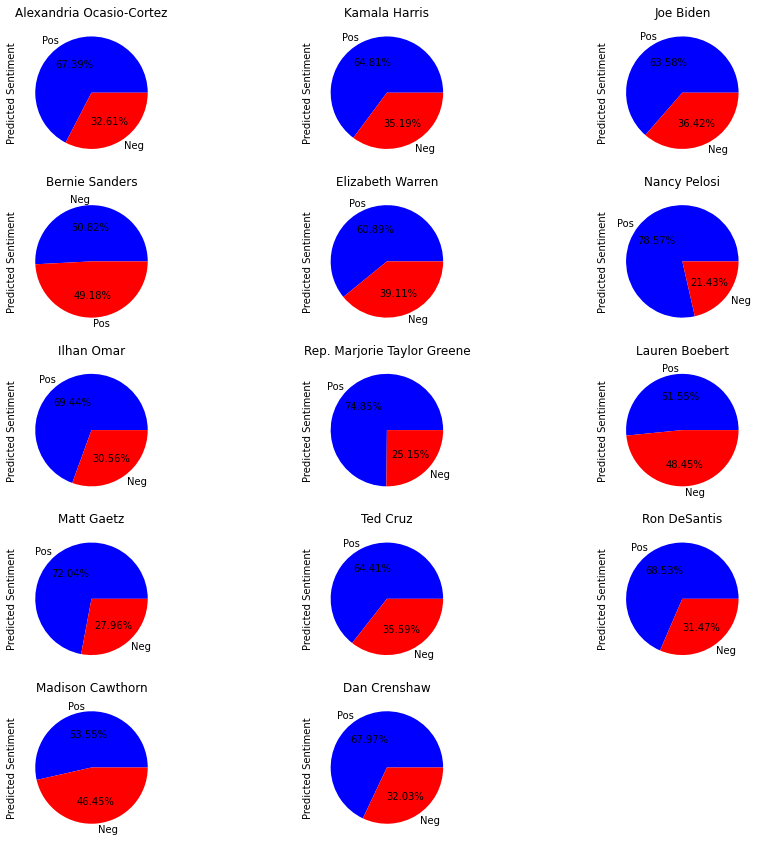

In [9]:
politicians = list(tweets_w_preds['User'].unique())
plt.figure(figsize=(15,15))
for i in enumerate(politicians):
    plt.subplot(5,3,i[0]+1)
    tweets_w_preds[tweets_w_preds['User']==i[1]]['Predicted Sentiment'].value_counts(normalize=True).plot(kind = 'pie',title=i[1],autopct='%1.2f%%',colormap='bwr')